In [1]:
%load_ext autoreload
import cbc, cbc_dp
import numpy as np, scipy as sp, matplotlib.pyplot as plt, h5py, pyqtgraph as pg
from numpy import ma
from scipy import constants
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Cython

In [45]:
%load_ext cython

In [46]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def model_source_lines(float_t[:, ::1] source, float_t[:, ::1] rec_vec, float_t num_ap_x, float_t num_ap_y):
    """
    Return source lines coordinates for a diffraction streaks model

    source - source line origins
    rec_vec - reciprocal vectors
    num_ap_x, num_ap_y - numerical apertires in x- and y-axes
    """
    cdef:
        int a = rec_vec.shape[0], ii = 0, jj, i, k
        uint8_t[::1] mask = np.zeros(a, dtype=np.uint8)
        float_t source_prd, coeff1, coeff2, alpha, betta, gamma, delta, sol_1, sol_2
        float_t[::1] bounds = np.array([num_ap_x, -num_ap_x, num_ap_y, -num_ap_y], dtype=np.float64)
        float_t[:, :, ::1] source_lines = np.empty((a, 2, 3), dtype=np.float64)
    for i in range(a):
        source_prd = (source[i, 0] * rec_vec[i, 0] + source[i, 1] * rec_vec[i, 1] + source[i, 2] * rec_vec[i, 2])
        jj = 0
        for k in range(4):
            coeff1 = source_prd - bounds[k] * rec_vec[i, k // 2]
            coeff2 = rec_vec[i, (3 - k) // 2]
            alpha = coeff2**2 + rec_vec[i, 2]**2
            betta = coeff2 * coeff1
            gamma = coeff1**2 - rec_vec[i, 2]**2 * (1 - bounds[k]**2)
            delta = betta**2 - alpha * gamma
            sol_1 = (betta + sqrt(delta)) / alpha
            sol_2 = (betta - sqrt(delta)) / alpha
            if abs(sol_1) < abs(bounds[3 - k]):
                source_lines[ii, jj, k // 2] = bounds[k]
                source_lines[ii, jj, (3 - k) // 2] = sol_1
                jj += 1
            if delta != 0 and abs(sol_2) < abs(bounds[3 - k]):
                source_lines[ii, jj, k // 2] = bounds[k]
                source_lines[ii, jj, (3 - k) // 2] = sol_2
                jj += 1
            if jj == 2:
                mask[i] = 1; ii += 1
                break
    return np.asarray(source_lines[:ii]), np.asarray(mask).astype(bool)

In [43]:
f135 = h5py.File("exp_results/scan_{0:05}/scan_corrected_{0:05}.h5".format(135), 'r')
frame = f135['corrected_data/streaks_data'][0]

In [58]:
from scipy import constants

pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rot_axis = np.array([0, 1, 0])
b12_det_pos = np.array([1470 * pix_size, 1710 * pix_size, 101.976])
b12_exp = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_pos=b12_det_pos,
                                    wavelength=wavelength)

In [63]:
lsd = cbc_dp.LineSegmentDetector()
raw_lines = hld.det_frame_raw(frame)
frame_strks = cbc_dp.FrameStreaks(raw_lines, b12_exp)

In [64]:
%time ref_lines = lsd._refiner(frame_strks.lines, frame_strks.taus, 5, 5)
%time ref_lines2 = lsd_refiner(frame_strks.lines, frame_strks.taus, 5, 5)
ref_lines.shape, ref_lines2.shape

CPU times: user 3.71 ms, sys: 423 µs, total: 4.13 ms
Wall time: 3.73 ms
CPU times: user 552 µs, sys: 372 µs, total: 924 µs
Wall time: 590 µs


((102, 2, 2), (102, 2, 2))

In [45]:
hld = cbc_dp.HoughLineDetector(10, 15, 5, np.pi / 100)
raw_lines = hld.det_frame_raw(frame)
frame_strks = cbc_dp.FrameStreaks(raw_lines, b12_exp)

In [51]:
%time ref_lines = hld._refiner(frame_strks.lines, frame_strks.taus, 5, 5)
%time ref_lines2 = hl_refiner(frame_strks.lines, frame_strks.taus, 5, 5)
ref_lines.shape, ref_lines2.shape

CPU times: user 3.72 ms, sys: 714 µs, total: 4.43 ms
Wall time: 3.76 ms
CPU times: user 592 µs, sys: 616 µs, total: 1.21 ms
Wall time: 631 µs


((97, 2, 2), (97, 2, 2))

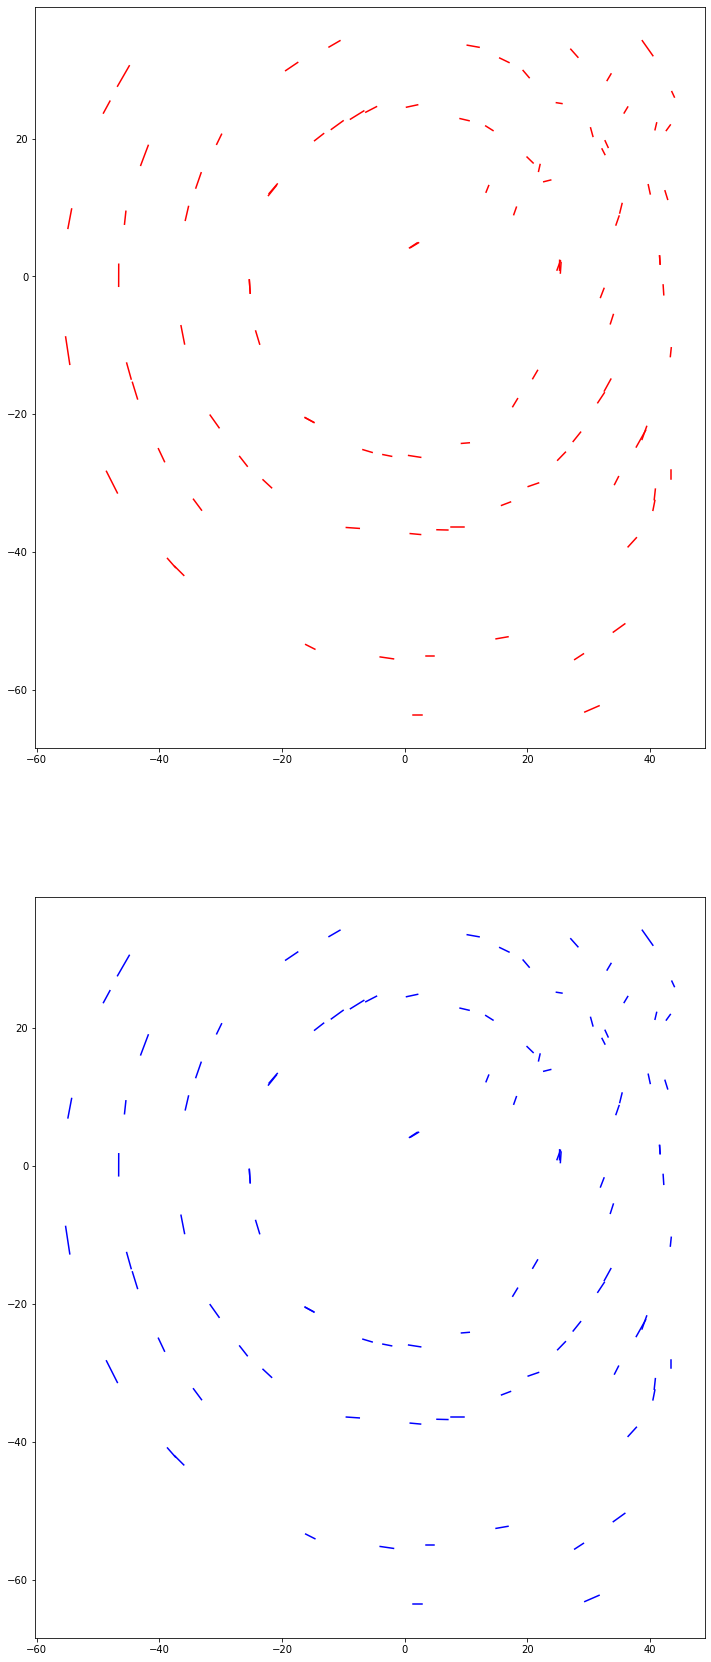

In [65]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(12, 30))
for line in ref_lines2:
    axes[0].plot(line[:, 0], line[:, 1], 'r')
for line in ref_lines:
    axes[1].plot(line[:, 0], line[:, 1], 'b')
plt.show()

# Indexing prototyping

In [2]:
def q_surface(kout, theta_s, phi_s):
    theta_grid, phi_grid = np.meshgrid(theta_s, phi_s)
    return kout[:, None, None] - np.stack([np.sin(theta_grid) * np.cos(phi_grid),
                                           np.sin(theta_grid) * np.sin(phi_grid),
                                           np.cos(theta_grid)], axis=-1)[None, :]

def kout(streaks):
    theta = np.arctan(np.sqrt(streaks[..., 0]**2 + streaks[..., 1]**2))
    phi = np.arctan2(streaks[..., 1], streaks[..., 0])
    return np.stack([np.sin(theta) * np.cos(phi),
                     np.sin(theta) * np.sin(phi),
                     np.cos(theta)], axis=-1)

num_ap, size = np.radians(30), 200
phi_n, theta_n, t = np.radians(10), np.radians(20), np.array([-0.05, 0.2, 0.4])
norm = np.array([np.tan(theta_n) * np.cos(phi_n), np.tan(theta_n) * np.sin(phi_n)])
streak = norm + np.multiply.outer(t, np.array([-np.sin(theta_n), np.cos(theta_n)]))
q_surfs = q_surface(kout(streak), np.linspace(0, num_ap, size), np.linspace(0, 2 * np.pi, size))

In [3]:
%gui qt
app = make_app()
w = SurfaceViewer()
w.set_data(x=np.linspace(0, num_ap, size),
           y=np.linspace(0, 2 * np.pi, size),
           z=q_surfs[0][..., -1],
           color=(1.0, 0.0, 0.0, 0.5))
w.set_data(x=np.linspace(0, num_ap, size),
           y=np.linspace(0, 2 * np.pi, size),
           z=q_surfs[1][..., -1],
           color=(0.0, 1.0, 0.0, 0.5))
w.show()

NameError: name 'make_app' is not defined

In [5]:
%gui qt
app = make_app()
w = ScatterViewer()
color = np.concatenate((np.array([255, 0, 0, 100]) * np.ones((size**2, 4)),
                        np.array([0, 255, 0, 100]) * np.ones((size**2, 4)),
                        np.array([0, 0, 255, 100]) * np.ones((size**2, 4))))
w.set_data(pos=q_surfs.reshape((-1, 3)), color=color, size=2)
w.show()

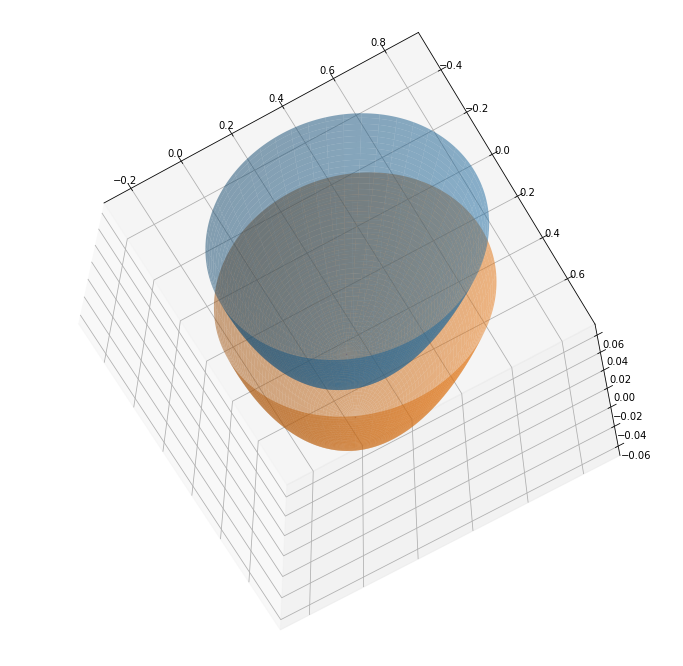

In [72]:
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-70)
for q_surf in q_surfs:
    ax.plot_surface(q_surf[..., 0], q_surf[..., 1], q_surf[..., 2], alpha=0.5)
plt.show()

# Square Aperture Model

In [2]:
wavelength = 1.14e-7
NA_x, NA_y = 0.015, 0.01
q_max = 0.7
a_rec = np.array([0.00551908483885947, -0.00294352907953398, 0.0109864094612009]) * 1e7
b_rec = np.array([-0.0112435046699143, 0.000431835526544485, 0.00576393741858660]) * 1e7
c_rec = np.array([-0.00357471961041716, -0.0255767535096894, -0.00505686021507011]) * 1e7
rot_m = cbc_dp.utils.rotation_matrix(np.array([0, 1, 0]), np.radians(63))
rec_basis = np.stack((a_rec, b_rec, c_rec)) * wavelength
rec_basis = rec_basis.dot(rot_m.T)
basis_sizes = np.sqrt((rec_basis**2).sum(axis=1))

In [3]:
wavelength = constants.h * constants.c / 17000 / constants.e
NA_x, NA_y = 1.5e8 * wavelength, 2.5e8 * wavelength
q_max = wavelength / 2.5 / 1e-10
rec_basis = np.array([[1e8, 0, 0],
                      [0, 2e8, 0],
                      [0, 0, 4e8]], dtype=np.float64) * wavelength / 2
rec_basis = rec_basis.dot(cbc_dp.utils.rotation_matrix(np.array([1, 0, 0]), np.radians(10)).T)
inv_basis = np.linalg.inv(rec_basis)
basis_sizes = np.sqrt((rec_basis**2).sum(axis=-1))

In [39]:
lat_size = np.rint(q_max / basis_sizes)
h_idxs = np.arange(-lat_size[0], lat_size[0] + 1)
k_idxs = np.arange(-lat_size[1], lat_size[1] + 1)
l_idxs = np.arange(-lat_size[2], lat_size[2] + 1)
h_grid, k_grid, l_grid = np.meshgrid(h_idxs, k_idxs, l_idxs)
hkl_idxs = np.stack((h_grid.ravel(), k_grid.ravel(), l_grid.ravel()), axis=1)
rec_vec = hkl_idxs.dot(rec_basis)
rec_abs = np.sqrt((rec_vec**2).sum(axis=1))
idxs = np.where((rec_abs != 0) & (rec_abs < q_max))
rec_vec, hkl_idxs = rec_vec[idxs], hkl_idxs[idxs]
rec_vec.shape

(267550, 3)

In [40]:
rec_abs = np.sqrt((rec_vec**2).sum(axis=-1))
rec_th = np.arccos(-rec_vec[..., 2] / rec_abs)
rec_phi = np.arctan2(rec_vec[..., 1], rec_vec[..., 0])

mask = np.abs(np.sin(rec_th - np.arccos(rec_abs / 2))) < np.sqrt(NA_x**2 + NA_y**2)

rec_vec, hkl_idxs = rec_vec[mask], hkl_idxs[mask]
rec_abs = np.sqrt((rec_vec**2).sum(axis=-1))
rec_th = np.arccos(-rec_vec[..., 2] / rec_abs)
rec_phi = np.arctan2(rec_vec[..., 1], rec_vec[..., 0])
source = np.stack((-np.sin(rec_th - np.arccos(rec_abs / 2)) * np.cos(rec_phi),
                   -np.sin(rec_th - np.arccos(rec_abs / 2)) * np.sin(rec_phi),
                   np.cos(rec_th - np.arccos(rec_abs / 2))), axis=-1)
rec_vec.shape

(5786, 3)

In [44]:
bounds = np.array([[[NA_x, 0], [-NA_x, 0], [0, NA_y], [0, -NA_y]]])
sol_m = np.array([[[0, 1], [0, 1], [1, 0], [1, 0]]])

coeff1 = (source * rec_vec).sum(axis=-1)[..., None] - (bounds * rec_vec[..., None, :2]).sum(axis=-1)
coeff2 = np.stack((rec_vec[..., 1], rec_vec[..., 1], rec_vec[..., 0], rec_vec[..., 0]), axis=-1)
alpha = coeff2**2 + rec_vec[..., None, 2]**2
betta = coeff2 * coeff1
gamma = coeff1**2 - rec_vec[..., None, 2]**2 * (1 - bounds.sum(axis=2)**2)
delta = betta**2 - alpha * gamma

solution = ma.concatenate((bounds + sol_m * ((betta + ma.sqrt(delta)) / alpha)[..., None],
                           bounds + sol_m * ((betta - ma.sqrt(delta)) / alpha)[..., None]), axis=1)
solution = ma.stack((solution[..., 0],
                     solution[..., 1],
                     np.sqrt(1 - solution[..., 0]**2 - solution[..., 1]**2)), axis=-1)
sol_mask = (np.abs(solution[..., 0]) <= NA_x) & (np.abs(solution[..., 1]) <= NA_y)

solution = solution[sol_mask.any(axis=1)]
rec_vec, source = rec_vec[sol_mask.any(axis=1)], source[sol_mask.any(axis=1)]
hkl_idxs = hkl_idxs[sol_mask.any(axis=1)]
rec_phi = np.arctan2(rec_vec[..., 1], rec_vec[..., 0])
rec_vec.shape, source.shape, solution.shape

((5057, 3), (5057, 3), (5057, 8, 3))

In [42]:
source_lines, mask = cbc_dp.utils.model_source_lines(source, rec_vec, NA_x, NA_y)
rec_vec[mask].shape

(5057, 3)

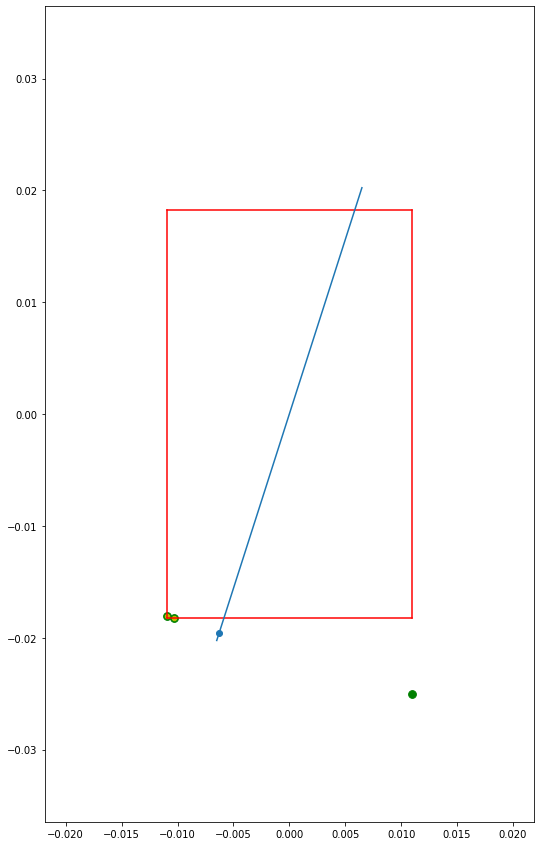

In [43]:
%matplotlib inline
NA_diag = np.sqrt(NA_x**2 + NA_y**2)
idx = 0
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.plot(NA_x * np.ones(50), np.linspace(-NA_y, NA_y), 'r')
ax.plot(-NA_x * np.ones(50), np.linspace(-NA_y, NA_y), 'r')
ax.scatter(solution[idx, ..., 0], solution[idx, ..., 1], 60, 'g')
ax.scatter(source_lines[idx, ..., 0], source_lines[idx, ..., 1], 20, 'y')
ax.plot(np.linspace(-NA_x, NA_x), NA_y * np.ones(50), 'r')
ax.plot(np.linspace(-NA_x, NA_x), -NA_y * np.ones(50), 'r')
ax.plot(np.linspace(-NA_diag, NA_diag) * np.cos(rec_phi[idx]),
        np.linspace(-NA_diag, NA_diag) * np.sin(rec_phi[idx]))
ax.scatter(source[idx, 0], source[idx, 1])
ax.set_xlim(-2 * NA_x, 2 * NA_x)
ax.set_ylim(-2 * NA_y, 2 * NA_y)
ax.set_aspect('equal')
plt.show()

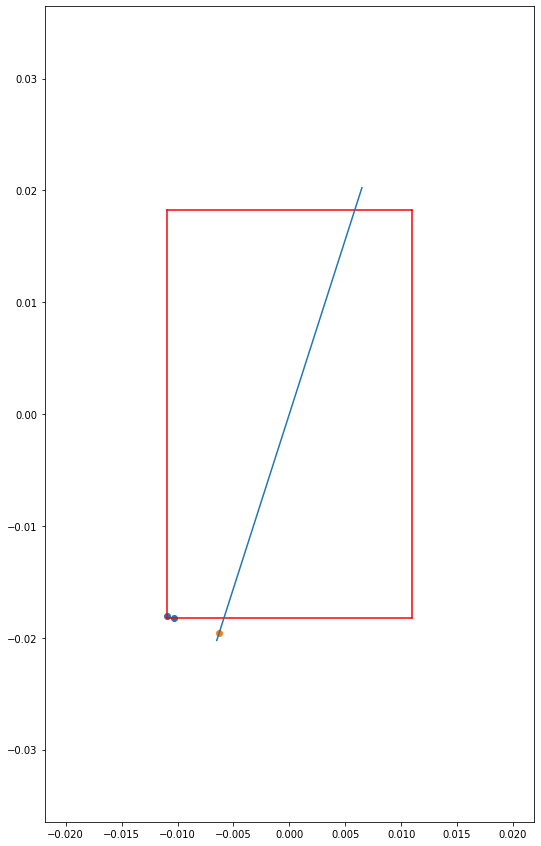

In [35]:
%matplotlib inline
rect_model = cbc_dp.RectModel(rec_basis,
                              num_ap=(NA_x, NA_y),
                              q_max=q_max)
NA_diag = np.sqrt(NA_x**2 + NA_y**2)
idx = 0
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.scatter(rect_model._source_lines[idx, ..., 0],
           rect_model._source_lines[idx, ..., 1])
ax.plot(NA_x * np.ones(50), np.linspace(-NA_y, NA_y), 'r')
ax.plot(-NA_x * np.ones(50), np.linspace(-NA_y, NA_y), 'r')
ax.plot(np.linspace(-NA_x, NA_x), NA_y * np.ones(50), 'r')
ax.plot(np.linspace(-NA_x, NA_x), -NA_y * np.ones(50), 'r')
ax.plot(np.linspace(-NA_diag, NA_diag) * np.cos(rect_model.rec_phi[idx]),
        np.linspace(-NA_diag, NA_diag) * np.sin(rect_model.rec_phi[idx]))
ax.scatter(rect_model.source[idx, 0], rect_model.source[idx, 1])
ax.set_xlim(-2 * NA_x, 2 * NA_x)
ax.set_ylim(-2 * NA_y, 2 * NA_y)
ax.set_aspect('equal')
plt.show()

In [39]:
det_dist = 50
det_qx, det_qy = det_pts(qx, qy, qz, det_dist)
det_ox, det_oy = det_pts(xs, ys, np.sqrt(1 - xs**2 - ys**2), det_dist)
det_kx, det_ky = det_pts(qx[:, np.newaxis] + xs,
                         qy[:, np.newaxis] + ys,
                         qz[:, np.newaxis] + np.sqrt(1 - xs**2 - ys**2),
                         det_dist)

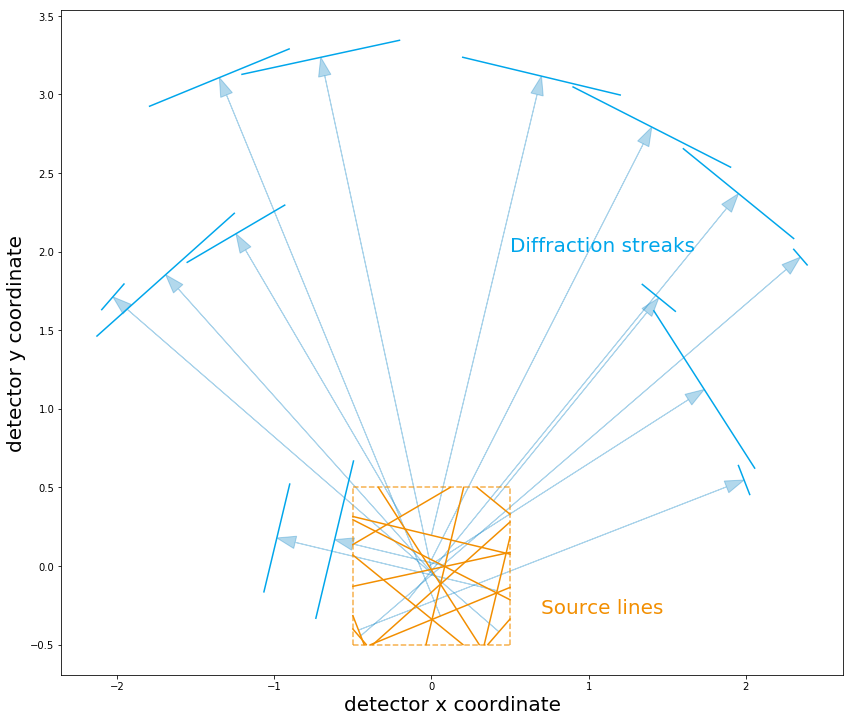

In [40]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
for k_x, k_y, o_x, o_y, q_x, q_y in zip(det_kx, det_ky, det_ox, det_oy, det_qx, det_qy):
    ax.plot(k_x, k_y, color=(0, 166 / 255, 235 / 255))
    ax.plot(o_x, o_y, color=(242 / 255, 142 / 255, 0))
    ax.arrow(o_x.mean(), o_y.mean(),
              k_x.mean() - o_x.mean(),
              k_y.mean() - o_y.mean(),
              length_includes_head=True,
              head_width=0.08,
              color=(0 / 255, 126 / 255, 195 / 255),
              ec=(0 / 255, 126 / 255, 195 / 255),
              aa=True,
              alpha=0.3)
ax.plot([-det_dist * NA, det_dist * NA],
         [det_dist * NA, det_dist * NA],
         color=(242 / 255, 142 / 255, 0),
         linestyle='dashed',
         alpha=0.7)
ax.plot([-det_dist * NA, det_dist * NA],
         [-det_dist * NA, -det_dist * NA],
         color=(242 / 255, 142 / 255, 0),
         linestyle='dashed',
         alpha=0.7)
ax.plot([det_dist * NA, det_dist * NA],
         [-det_dist * NA, det_dist * NA],
         color=(242 / 255, 142 / 255, 0),
         linestyle='dashed',
         alpha=0.7)
ax.plot([-det_dist * NA, -det_dist * NA],
         [-det_dist * NA, det_dist * NA],
         color=(242 / 255, 142 / 255, 0),
         linestyle='dashed',
         alpha=0.7)
ax.set_xlabel('detector x coordinate', fontsize=20)
ax.set_ylabel('detector y coordinate', fontsize=20)
ax.text(0.5, 2.0, 'Diffraction streaks', fontsize=20, color=(0, 166 / 255, 235 / 255))
ax.text(0.7, -0.3, 'Source lines', fontsize=20, color=(242 / 255, 142 / 255, 0))
ax.set_aspect('equal')
plt.show()

In [28]:
roi = 30
circ_prop = CircPropagator(rec_lat=cbc.RecLattice(arec, brec, crec, q_max=0.4, wavelength=wavelength), num_ap=0.015)
exit_x, exit_y, exit_z = circ_prop.exit_pts()
entry_x, entry_y, entry_z = circ_prop.entry_pts()
det_x_exit, det_y_exit = det_pts(exit_x, exit_y, exit_z, det_dist)
det_x_entry, det_y_entry = det_pts(entry_x, entry_y, entry_z, det_dist)
det_x, det_y = circ_prop.detector_pts(det_dist)
det_x, det_y = (det_x[(np.abs(det_x) < roi).any(axis=1) & (np.abs(det_y) < roi).any(axis=1)],
                det_y[(np.abs(det_x) < roi).any(axis=1) & (np.abs(det_y) < roi).any(axis=1)])
det_x.shape

(27, 2)

# Simulation results

In [2]:
from scipy import constants



In [12]:
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
NA_x, NA_y = 2.5e5 * wavelength, 3e5 * wavelength
q_max = 0.6
rec_basis = np.array([[2e5, 0, 0],
                      [0, 2.5e5, 0],
                      [0, 0, 3e5]], dtype=np.float64) * wavelength
rec_basis *= 1.4
rec_basis = rec_basis.dot(cbc_dp.utils.rotation_matrix(np.array([1, 0, 0]), np.radians(20)).T)
rec_basis = rec_basis.dot(cbc_dp.utils.rotation_matrix(np.array([0, 1, 0]), np.radians(7)).T)
inv_basis = np.linalg.inv(rec_basis)
basis_sizes = np.sqrt((rec_basis**2).sum(axis=-1))

pix_size = 75 * 1e-3
rot_axis = np.array([0, 1, 0])
b12_det_pos = np.array([1000 * pix_size, 1000 * pix_size, 100])
b12_exp = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_pos=b12_det_pos,
                                    wavelength=wavelength)

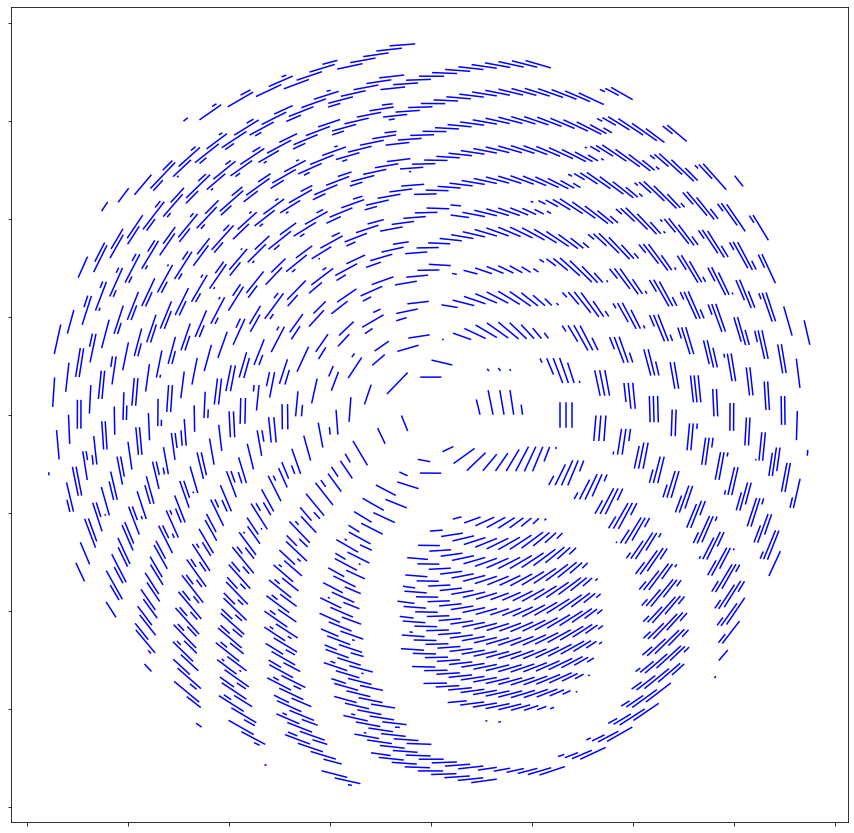

In [13]:
%matplotlib inline
rect_model = cbc_dp.RectModel(rec_basis,
                              num_ap=(NA_x, NA_y),
                              q_max=q_max)
det_lines = rect_model.det_lines(b12_exp)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
for line in det_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
plt.show()

In [58]:
from scipy import constants

pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rot_axis = np.array([0, 1, 0])
b12_det_pos = np.array([1470 * pix_size, 1710 * pix_size, 101.976])
b12_exp = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_pos=b12_det_pos,
                                    wavelength=wavelength)

In [49]:
datapath = 'data/data'
res1 = h5py.File('results/diff_06-09-2019_22-41-28.hdf5', 'r')[datapath]
res2 = h5py.File('results/diff_07-09-2019_05-32-33.hdf5', 'r')[datapath]
res3 = h5py.File('results/diff_25-09-2019_08-17-22.hdf5', 'r')[datapath]

pix_size = 75 * 1e-3

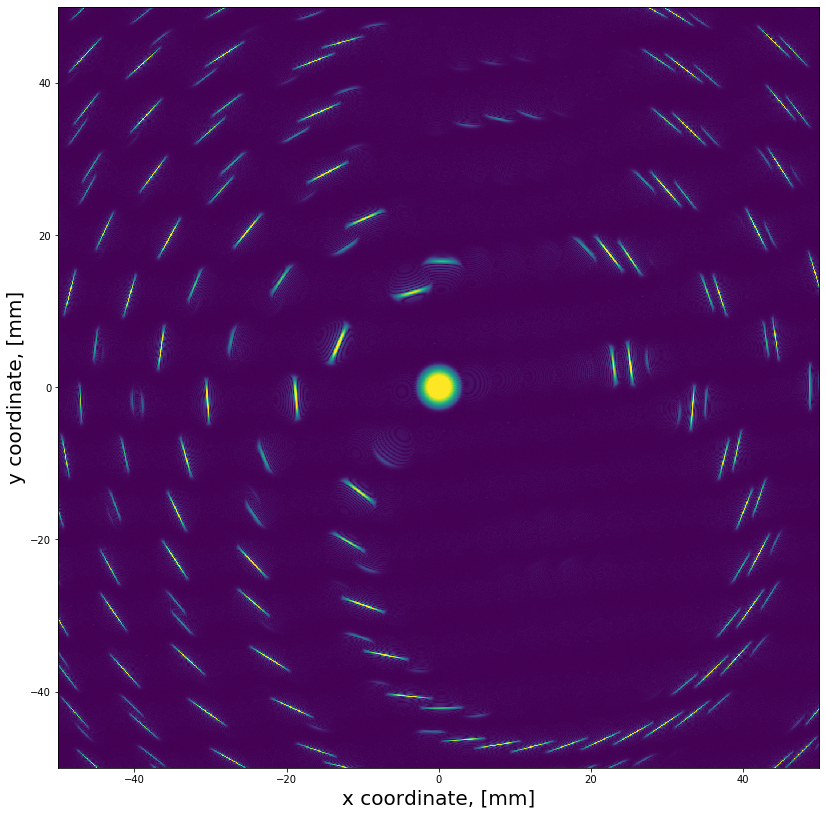

In [51]:
%matplotlib inline
roi = pix_size * np.array([0, res2.shape[1], res2.shape[0], 0])
zero = pix_size * np.array([res2.shape[0], res2.shape[1]]) / 2
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
ax.imshow(np.abs(res1), vmax=0.7*np.abs(res2).max(), extent=[roi[0] - zero[0], roi[1] - zero[0], roi[2] - zero[1], roi[3] - zero[1]])
# for x, y in zip(det_x, det_y):
#     plt.plot(x, y, 'r', alpha=0.6)
# ax.scatter(xs2.mean(axis=1), ys2.mean(axis=1), 10, 'b')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_xlabel('x coordinate, [mm]', fontsize=20)
ax.set_ylabel('y coordinate, [mm]', fontsize=20)
plt.show()

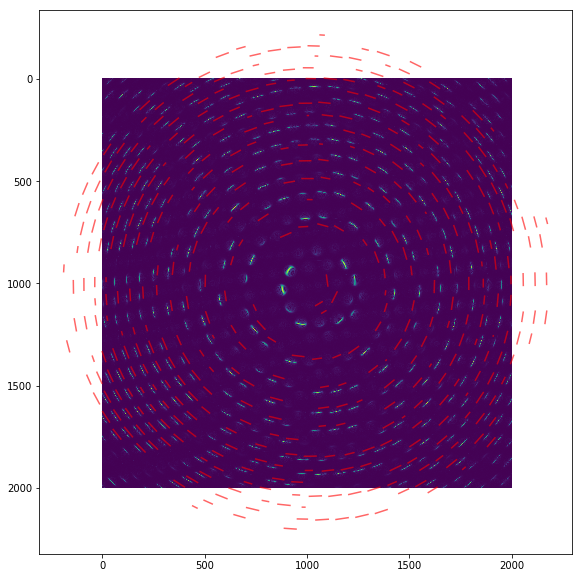

In [69]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(res3))
for x, y in zip(xs2, ys2):
    plt.plot(x / pix_size + zero[0], y / pix_size + zero[1], 'r', alpha=0.6)
plt.show()

# Gaussian beam

In [38]:
def thdiv(waist, wavelength):
    return wavelength / np.pi / waist

def zR(waist, wavelength):
    return np.pi * waist**2 / wavelength

def R(zs, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    return zs + zr**2 / zs

def wz(z, waist, wavelength):
    return waist * np.sqrt(1 + (z / zR(waist, wavelength)**2))

def gaussian(xs, ys, zs, waist=1e-4, wavelength=1.5e-7):
    k = 2 * np.pi / wavelength
    zr = np.pi * waist**2 / wavelength
    Rs = zs + zr**2 / zs
    wz = waist * sqrt(1 + z**2 / zr**2)
    return np.pi**-1 * waist**-1 * wz**-1 * np.exp(-(xs**2 + ys**2) / wz**2) * np.exp(-1j * (k * z - np.arctan(zs / zr) + k * (xs**2 + ys**2) / 2 / Rs))

In [39]:
thdiv(waist, wavelength)

0.0477464829275686

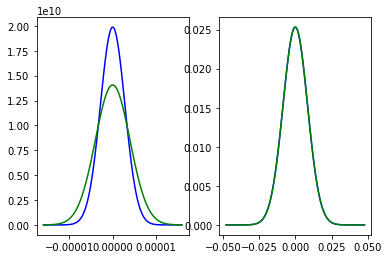

In [50]:
%matplotlib inline
xs = np.linspace(-4 * waist, 4 * waist, 100)
us = np.abs(cbc.gaussian(xs, 0, 0, waist, wavelength))
us2 = np.abs(cbc.gaussian(xs, 0, zR(waist, wavelength), waist, wavelength))
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
ufs = np.abs(cbc.gaussian_f(kxs, 0, 0, waist, wavelength))
ufs2 = np.abs(cbc.gaussian_f(kxs, 0, zR(waist, wavelength), waist, wavelength))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xs, us, 'b-', xs, us2, 'g-')
ax2.plot(kxs, ufs, 'b-', kxs, ufs2, 'g-')
plt.show()

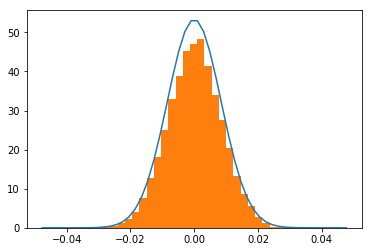

In [34]:
%matplotlib inline
knum = 10000
ks = cbc.gaussian_dist(knum, 0, waist, wavelength)
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength))
us = np.abs(cbc.gaussian_f(kxs, 0, 10, waist, wavelength)) * 4 * np.pi / thdiv(waist, wavelength)*2
plt.plot(kxs, us)
plt.hist(ks[:,0], 30, density=True)
plt.show()

In [ ]:
%matplotlib inline
_thdiv = thdiv(waist,wavelength)
kxs, kys = cbc.uniform_dist(100000, waist, wavelength)[:, 0:2].T
kxs2, kys2 = cbc.gaussian_dist(100000, waist, wavelength)[:, 0:2].T
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.hist2d(kxs, kys, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
ax2.hist2d(kxs2, kys2, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
plt.show()

# Convolution approximation and Henry's equations

In [3]:
def gaussian_dist(N, z, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    wz = waist * np.sqrt(1 + z**2 / zr**2)
    thdiv = wavelength / np.pi / wz
    kxs, kys = np.random.multivariate_normal([0, 0], [[thdiv**2 / 2, 0], [0, thdiv**2 / 2]], N).T
    return cbc.kout_parax(kxs, kys)

In [40]:
waist = 3e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 10, 10, 1
detNx, detNy = 64, 64
pix_size = 2 * 55e-3
det_dist = 30
knum = 5000

In [4]:
%matplotlib inline
XS, YS, ZS = np.array([0, 0.5 * a]), np.zeros(2), np.zeros(2)
els = ['Au', 'Ag']; bs = np.zeros(2)
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz, XS, YS, ZS)
z0 = 1e-4
zs += z0
asf_coeffs = cbc.asf_coeffs(els, bs)
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
us = cbc.gaussian(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)
print(asf_coeffs.shape)

(2, 11)


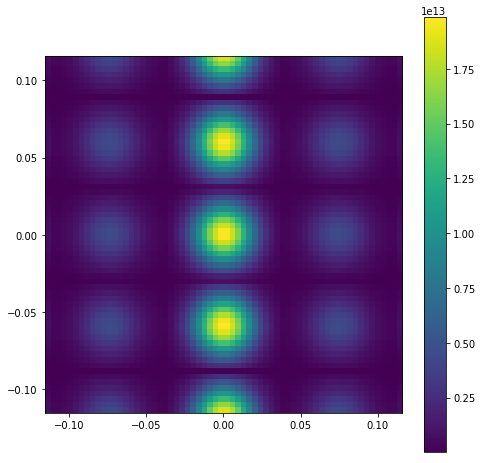

In [80]:
qabs = cbc.utils.q_abs(kouts, kins, wavelength)
asfs = cbc.utils.asf_sum(qabs, asf_coeffs)
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs * us * phs).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(8, 8))
plt.imshow(ints, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

In [81]:
%time kjs = np.repeat(cbc.gaussian_dist(knum, waist, wavelength)[:,np.newaxis], xs.shape[-1], axis=1)
%time qabs2 = cbc.utils.q_abs(kouts, kjs, wavelength)
%time asfs2 = cbc.utils.asf_sum(qabs2, asf_coeffs)
%time phs2 = cbc.utils.phase_conv(kouts, kjs, xs, ys, zs, wavelength)
%time sfs2 = asfs2 * phs2
print(kjs.shape, qabs2.shape, asfs2.shape, phs2.shape)

CPU times: user 1.13 ms, sys: 533 µs, total: 1.66 ms
Wall time: 1.13 ms
CPU times: user 480 ms, sys: 203 ms, total: 683 ms
Wall time: 680 ms
CPU times: user 2.03 s, sys: 102 ms, total: 2.13 s
Wall time: 2.12 s
CPU times: user 1min 16s, sys: 416 ms, total: 1min 17s
Wall time: 1min 16s
CPU times: user 248 ms, sys: 197 ms, total: 445 ms
Wall time: 443 ms
(5000, 2, 3) (4096, 5000, 2) (4096, 5000, 2) (4096, 5000, 2)


In [82]:
uphs = cbc.gaussian_f(kjs[:,:,0], kjs[:,:,1], z0, waist, wavelength)
res2 = (uphs * sfs2).sum(axis=(-2,-1)).reshape(kxs.shape) / kjs.shape[0]
print(uphs.shape, res2.shape)

(5000, 2) (64, 64)


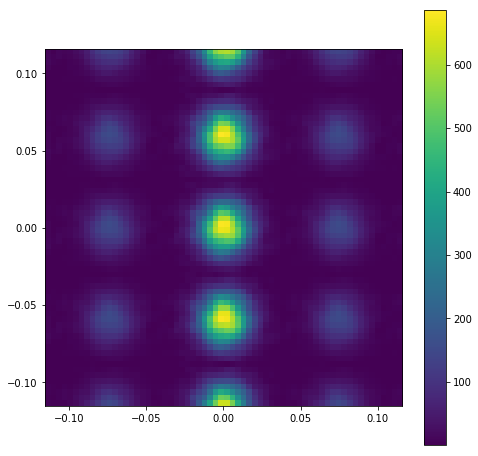

In [83]:
ints2 = np.abs(res2)
plt.figure(figsize=(8, 8))
plt.imshow(ints2, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

# Lysozyme diffraction pattern

In [42]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2.2e-2, 1e-4
waist = 4.5e-6
a, b, c = np.array([7.9e-6, 0, 0]), np.array([0, 7.9e-6, 0]), np.array([0, 0, 3.8e-6])
Nx, Ny, Nz = 20, 20, 20
r = 2e-4
detNx, detNy = 512, 512
pix_size = 55e-3
det_dist = 60

In [44]:
bragg = wavelength / 2 / np.sqrt(a.dot(a))
th_lens = 2 * ap / f
th_lens2 = 2 * wavelength / np.pi / waist
print(2 * bragg / th_lens, 2 * bragg / pix_size * det_dist)

0.863060989643268 20.713463751438432


In [45]:
beam = cbc.CircBeam(f, ap, wavelength)
diff = cbc.Diff(beam=beam,
                detector=cbc.Detector(det_dist=det_dist, detNx=detNx, detNy=detNy, pix_size=pix_size),
                lattice=cbc.BallLattice(cell=cbc.Cell.importpdb('4et8.pdb'), a=a, b=b, c=c, r=r))

In [ ]:
diffres = diff.calculate().pool()
diffres.write()

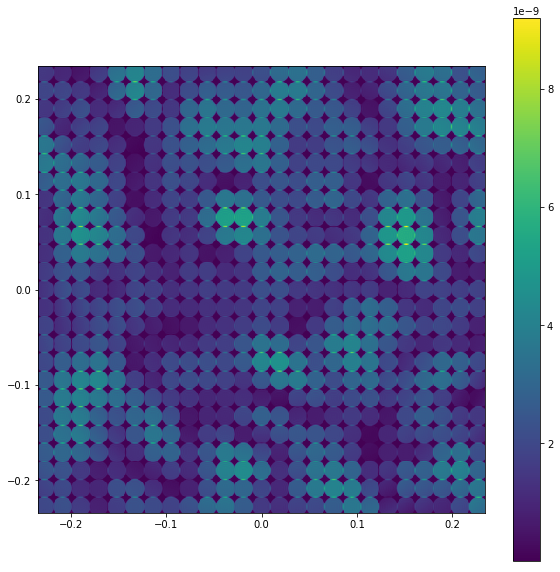

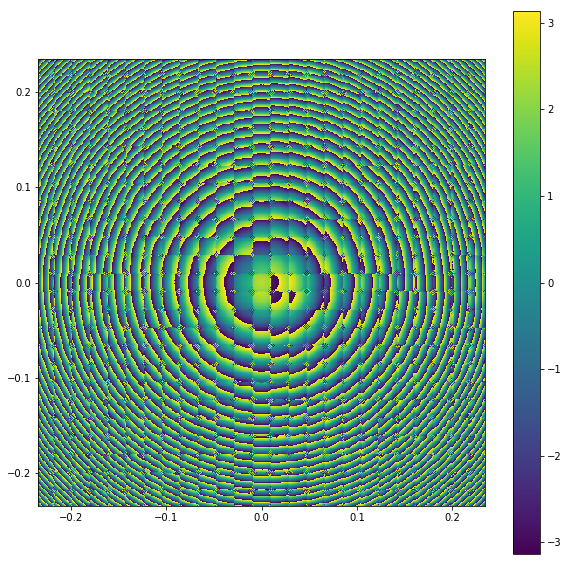

In [76]:
ints = np.abs(data[0])
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()
ang1 = np.angle(data[0])
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

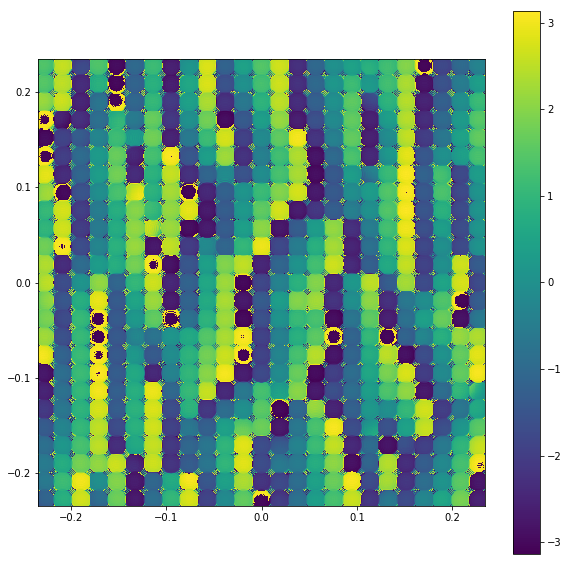

In [157]:
ang2 = np.angle(data[0] / np.exp(2j * np.pi / wavelength * 1e-4 * (1 - (data[1]**2 + data[2]**2) / 2)))
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

# Output values at the centers of diffraction orders

In [19]:
import numba as nb
from math import exp, cos, sin, pi

In [24]:
@nb.njit(nb.float64[:,:](nb.float64[:], nb.float64[:,:]), fastmath=True)
def asf_sum(ss, asfcoeffs):
    a = ss.size
    b = asfcoeffs.shape[0]
    asfs = np.empty((a, b), dtype=np.float64)
    ss = np.ascontiguousarray(ss)
    asfcoeffs = np.ascontiguousarray(asfcoeffs)
    for i in range(a):
        for j in range(b):
            dasf = 0.0
            for k in range(5):
                dasf += asfcoeffs[j,k] * exp(-ss[i]**2 * asfcoeffs[j,6+k])
            asfs[i,j] = (dasf + asfcoeffs[j,5]) * exp(-ss[i]**2 * asfcoeffs[j,-1])
    return asfs

@nb.njit(nb.complex128[:,:](nb.float64[:,:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64), fastmath=True)
def phase(kouts, xs, ys, zs, wavelength):
    a = kouts.shape[0]
    b = xs.size
    res = np.empty((a, b), dtype=np.complex128)
    kouts = np.ascontiguousarray(kouts)
    xs = np.ascontiguousarray(xs)
    ys = np.ascontiguousarray(ys)
    zs = np.ascontiguousarray(zs)
    for i in range(a):
        for j in range(b):
            _ph = kouts[i,0] * xs[j] + kouts[i,1] * ys[j] + kouts[i,2] * zs[j]
            res[i,j] = cos(2 * pi / wavelength * _ph) + sin(2 * pi / wavelength * _ph) * 1j
    return res

def gaussian_f(kxs, kys, zs, wavelength):
    return np.exp(-2j * np.pi / wavelength * np.multiply.outer((kxs**2 + kys**2) / 2, zs))

In [11]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2e-2, 1e-4
waist = 6.5e-6
a, b, c = 7.9e-6, 7.9e-6, 3.8e-6
Nx, Ny, Nz = 20, 20, 1
H, K = 10, 10
pix_size = 1/a
det_dist = 1/wavelength

In [28]:
XS = np.array([-0.5*a, -0.5*a, 0.5*a, 0.5*a])
YS = np.array([-0.5*a, 0.5*a, -0.5*a, 0.5*a])
ZS = np.array([-0.9*c, -0.9*c, 0.9*c, 0.9*c])
bs = np.repeat(25, 4)
elems = ['Au', 'Ag', 'Au', 'Ag']

In [7]:
XS = np.array([-0.5*a, 0.5*a])
YS = np.array([0.5*a, -0.5*a])
ZS = np.array([-0.9*c, 0.9*c])
bs = np.repeat(25, 2)
elems = ['Au', 'Ag']

In [29]:
beam = cbc.GausBeam(waist, wavelength)
diff = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff.move_lat([0.5 * a, 0.5 * b, 1e-3])

In [30]:
diffres = diff.henry().pool()
res, kxs, kys = diffres.res, diffres.kxs, diffres.kys

In [31]:
XS, YS, ZS, bs, elems = cbc.utils.pdb.importpdb('4et8.pdb')
gxs, gys = cbc.det_kouts(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size)
gs = np.stack((gxs.ravel(), gys.ravel(), np.repeat(0, gxs.size)), axis=-1)
ss = np.sqrt(gs*gs).sum(axis=-1) / wavelength / 2e7
asfcoeffs = cbc.asf_coeffs(elems, bs, wavelength)
asfs = asf_sum(ss.ravel(), asfcoeffs)
phs = phase(gs, XS, YS, ZS, wavelength)
ufs = gaussian_f(gxs.ravel(), gys.ravel(), ZS, wavelength)
Fs = (asfs * phs * ufs).sum(axis=-1).reshape(gxs.shape)
print(asfs.shape, phs.shape, ufs.shape, Fs.shape)

(441, 1001) (441, 1001) (441, 1001) (21, 21)


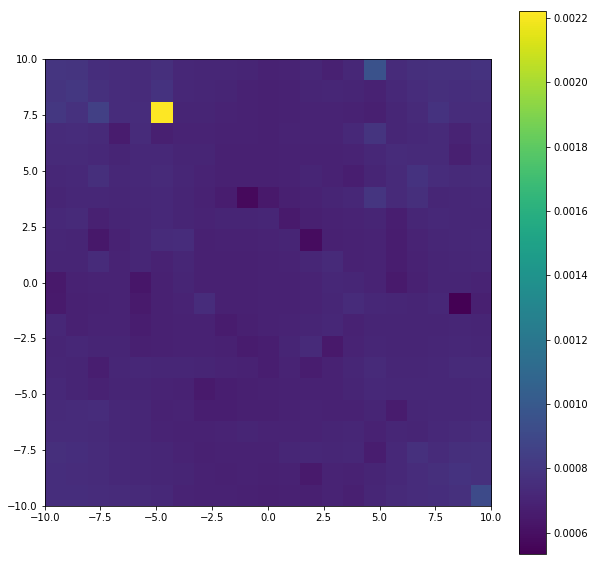

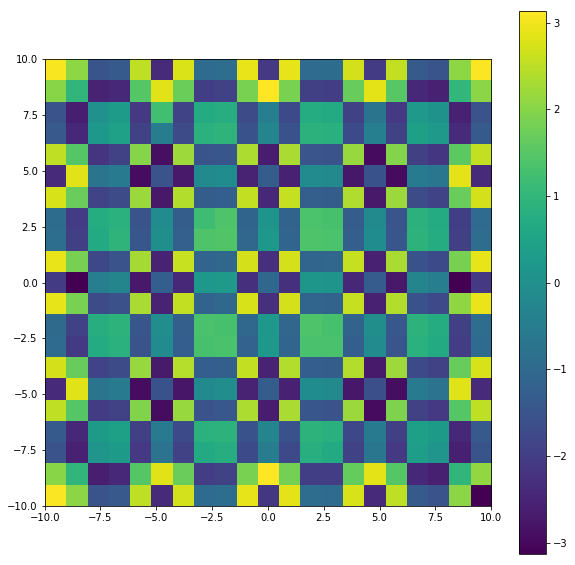

In [32]:
ints2 = np.abs(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ints2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang2 = np.angle(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

# Output values in overlap regions

In [153]:
diff2 = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff2.move_lat([0.5 * a, 0.5 * b, 0.0])

In [154]:
diffres2 = diff2.henry().pool()
res2, kxs2, kys2 = diffres2.res, diffres2.kxs, diffres2.kys

In [142]:
kouts = cbc.kout_parax(kxs2.ravel(), kys2.ravel())
gxs1, gys1 = gxs[:, 0:2*H], gys[:, 0:2*H]
gxs2, gys2 = gxs[:, 1:2*H+1], gys[:, 1:2*H+1]
gs1 = np.stack((gxs1.ravel(), gys1.ravel(), np.repeat(0, gxs1.size)), axis=-1)
gs2 = np.stack((gxs2.ravel(), gys2.ravel(), np.repeat(0, gxs2.size)), axis=-1)
ss1 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
ss2 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
asfs1 = asf_sum(ss1.ravel(), asfcoeffs)
asfs2 = asf_sum(ss2.ravel(), asfcoeffs)
phs1 = phase(gs1, XS, YS, ZS, wavelength)
phs2 = phase(gs2, XS, YS, ZS, wavelength)
ufs1 = gaussian_f(gxs1.ravel(), gys1.ravel(), ZS, wavelength)
ufs2 = gaussian_f(gxs2.ravel(), gys2.ravel(), ZS, wavelength)
Fs1 = (asfs1 * phs1 * ufs1).sum(axis=-1).reshape(gxs1.shape)
Fs2 = (asfs2 * phs2 * ufs2).sum(axis=-1).reshape(gxs2.shape)
OLs = Fs1 + Fs2

In [10]:
ints4 = np.abs(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ints4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang4 = np.angle(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ang4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

NameError: name 'OLs' is not defined

# Lens beam

In [70]:
wavelength = 1.5e-7
f, ap, defoc = 2, 8e-2, 1e-4
a, b, c = 2e-6, 2e-6, 1e-5
Nx, Ny, Nz = 60, 60, 1
detNx, detNy = 128, 128
pix_size = 55e-3 / 2
det_dist = 30

In [71]:
print(wavelength / a, 2 * ap / f)

0.075 0.08


In [79]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
zs += 1e-4
xs -= 0.5001 * a
ys -= 0.5001 * b
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
Rs = np.sqrt(xs**2 + ys**2 + zs**2)
kins = cbc.lensbeam_kins(xs, ys, zs, f, wavelength)
us = cbc.cbeam(xs, ys, zs, f, ap, wavelength)

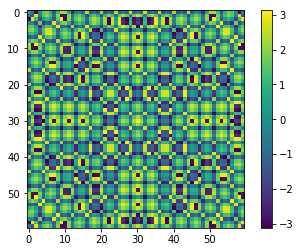

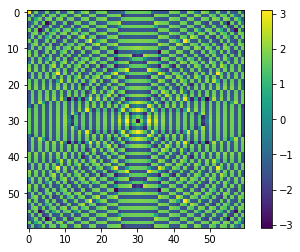

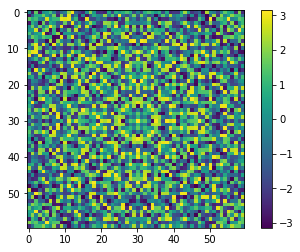

In [80]:
phin1 = (np.exp(1j) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)).reshape((Nx, Ny))
angs1 = np.angle(phin1)
angs2 = np.angle(np.exp(1j * np.pi) * np.exp(-1j * np.pi * 1e-2 / wavelength * (xs**2 + ys**2) / Rs**2)).reshape((Nx, Ny))
angs3 = -np.angle(us).reshape(Nx, Ny)
plt.imshow(angs1)
plt.colorbar()
plt.show()
plt.imshow(angs3)
plt.colorbar()
plt.show()
plt.imshow(angs2)
plt.colorbar()
plt.show()

In [82]:
qs_abs = cbc.utils.q_abs(kouts, kins, wavelength)
asf_coeffs1 = cbc.asf_coeffs()
%time asfs1 = cbc.utils.asf_sum(qs_abs, asf_coeffs1)
qs_abs.shape

CPU times: user 3.03 s, sys: 141 ms, total: 3.17 s
Wall time: 3.16 s


(16384, 3600, 1)

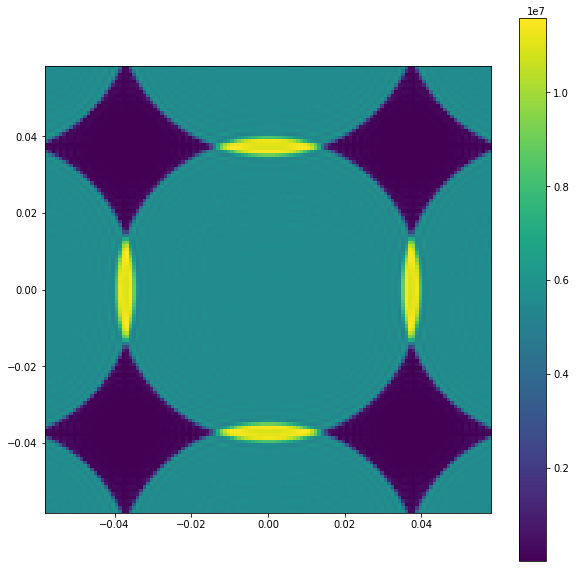

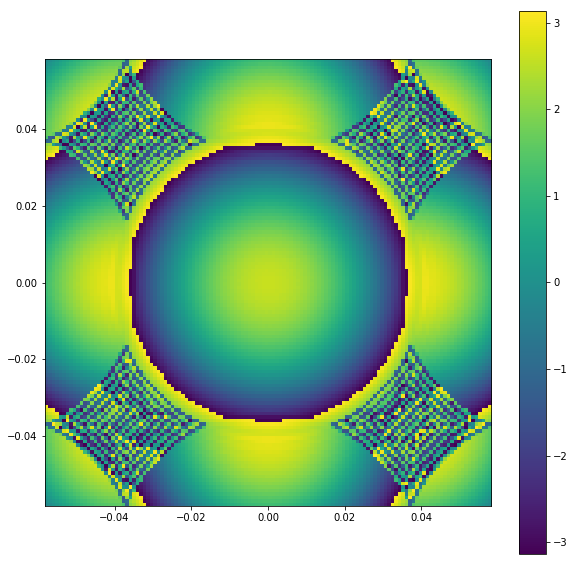

In [85]:
%matplotlib inline
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs1 * phs * us).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()
ang1 = np.angle(res)
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

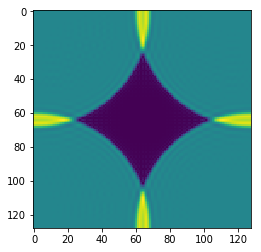

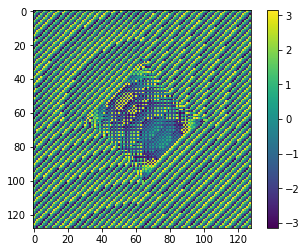

In [86]:
res2 = np.fft.fft2(us.reshape((Nx, Ny)), kxs.shape)
ints2 = np.abs(res2)
plt.imshow(ints2)
plt.show()
ang2 = np.angle(res2)
plt.imshow(ang2)
plt.colorbar()
plt.show()